In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

Using TensorFlow backend.






58892288/58889256 [==============================] - 42s 1us/step








In [3]:
 conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


In [5]:
base_dir = 'drive/My Drive/Colab Notebooks'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 300)
validation_features, validation_labels = extract_features(validation_dir, 112)
test_features, test_labels = extract_features(test_dir, 112)

train_features = np.reshape(train_features, (300, 4*4* 512))
validation_features = np.reshape(validation_features, (112, 4*4* 512))
test_features = np.reshape(test_features, (112, 4*4* 512))

Found 308 images belonging to 14 classes.
Found 112 images belonging to 14 classes.
Found 112 images belonging to 14 classes.


In [6]:
from keras import models
from keras import layers
from keras import optimizers 
from keras.utils import to_categorical
import matplotlib.pyplot as plt
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(14, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5, rho=0.9),
              metrics=['accuracy'])          
history = model.fit(train_features,to_categorical(train_labels),
epochs=30,
batch_size=10,
validation_data=(validation_features, to_categorical(validation_labels)))




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 300 samples, validate on 112 samples
Epoch 1/30
300/300 [==============================] - 1s 4ms/step - loss: 2.6110 - acc: 0.1067 - val_loss: 2.4748 - val_acc: 0.2054
Epoch 2/30
300/300 [==============================] - 1s 2ms/step - loss: 2.4229 - acc: 0.2433 - val_loss: 2.3109 - val_acc: 0.4464
Epoch 3/30
300/300 [==============================] - 1s 2ms/step - loss: 2.2631 - acc: 0.4567 - val_loss: 2.1316 - val_acc: 0.7768
Epoch 4/30
300/300 [==============================] - 1s 2ms/step - loss: 2.0788 - acc: 0.6400 - val_loss: 1.9213 - val_acc: 0.9196
Epoch 5/30
300/300 [==============================] - 1s 2ms/step - loss: 1.8631 - acc: 0.7667 - val_loss: 1.6850 - val_acc: 0.9643
Epoch 6/30
300/300 [==============================] - 1s 3ms/step - loss: 1.6333

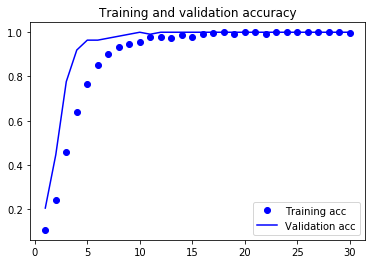

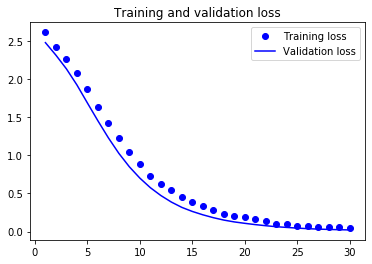

In [7]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
model.save('drive/My Drive/Colab Notebooks/feature_extraction_basic2.h5')

In [9]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(14, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 14)                3598      
Total params: 16,815,694
Trainable params: 16,815,694
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))
#This is the number of trainable weights before freezing the conv base: 30
conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))
#This is the number of trainable weights after freezing the conv base: 4

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
# base_dir = 'drive/My Drive/Colab Notebooks'
# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=10,
class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=10,
class_mode='categorical')
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=2e-5),
metrics=['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=10,
validation_data=validation_generator,
validation_steps=50)

Found 308 images belonging to 14 classes.
Found 112 images belonging to 14 classes.
Epoch 1/10
100/100 [==============================] - 325s 3s/step - loss: 2.5174 - acc: 0.2458 - val_loss: 2.2888 - val_acc: 0.6368
Epoch 2/10
100/100 [==============================] - 324s 3s/step - loss: 2.1814 - acc: 0.5435 - val_loss: 1.8263 - val_acc: 0.8568
Epoch 3/10
100/100 [==============================] - 325s 3s/step - loss: 1.7397 - acc: 0.7498 - val_loss: 1.2890 - val_acc: 0.9615
Epoch 4/10
100/100 [==============================] - 324s 3s/step - loss: 1.3196 - acc: 0.8637 - val_loss: 0.8499 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 325s 3s/step - loss: 0.9801 - acc: 0.9310 - val_loss: 0.5598 - val_acc: 0.9915
Epoch 6/10
100/100 [==============================] - 324s 3s/step - loss: 0.7208 - acc: 0.9505 - val_loss: 0.3753 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 326s 3s/step - loss: 0.5810 - acc: 0.9615 - val_loss: 0.2548 - v

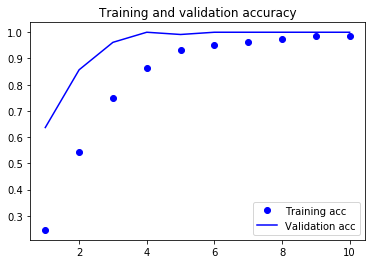

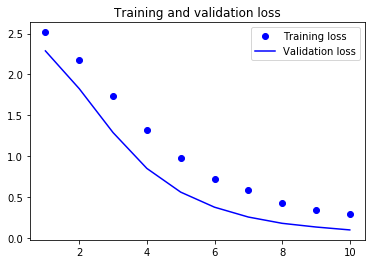

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [22]:
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=2e-5),
metrics=['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=10,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/10
100/100 [==============================] - 399s 4s/step - loss: 0.0270 - acc: 0.9920 - val_loss: 3.9462e-04 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 401s 4s/step - loss: 0.0135 - acc: 0.9940 - val_loss: 1.2802e-04 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 400s 4s/step - loss: 0.0146 - acc: 0.9980 - val_loss: 9.0453e-05 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 400s 4s/step - loss: 0.0207 - acc: 0.9948 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 398s 4s/step - loss: 0.0144 - acc: 0.9950 - val_loss: 3.9158e-05 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 396s 4s/step - loss: 0.0146 - acc: 0.9960 - val_loss: 4.2634e-05 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 398s 4s/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.2671e-06 - val_acc: 1.0000
Epoch 8/10
100/100 [=========================

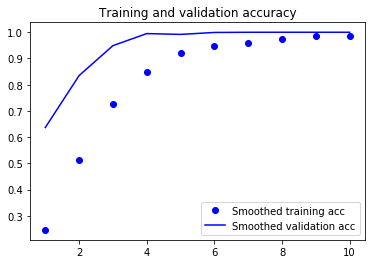

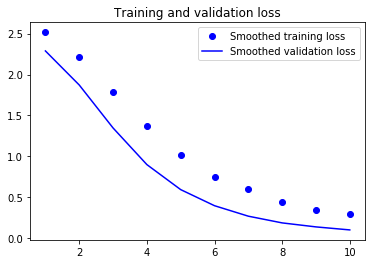

In [25]:
def smooth_curve(points, factor=0.1):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
        smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
  smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
  smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,
  smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
  smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [29]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=10,
class_mode='categorical')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 112 images belonging to 14 classes.
test acc: 1.0
